In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchsummary
from torch.autograd import Variable
from copy import deepcopy
from itertools import chain
import math

from PIL import Image

In [2]:
num_epochs = 5
batch_size = 64
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
transform = transforms.ToTensor()

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform);
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True);

val_data = datasets.MNIST('./data', train=False, download=True, transform=transform);
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False);

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_data), 'val': len(val_data)}

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


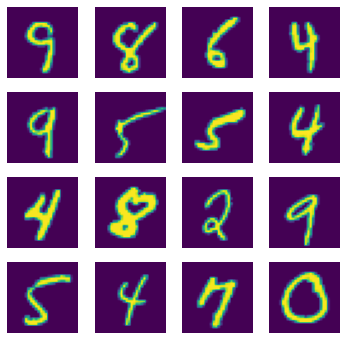

In [4]:
fig = plt.figure(figsize=(6,6))
for i in range(16):
  index = np.random.randint(len(train_data))
  img, label = train_data[index]
  fig.add_subplot(4, 4, i+1)
#  plt.title('label: {}'.format(label))
  plt.axis('off')
  plt.imshow(torch.reshape(img, (28,28)))

### Find learning rate

In [125]:
# не используется

def find_lr(model, dataloader, optimizer, init_value = 1e-8, final_value=10., beta = 0.98):
    #based on https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html

    num = len(dataloader.dataset)-1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0
    losses = []
    log_lrs = []
    for inputs,labels in dataloader:
        batch_num += 1
      #  print(inputs.size())
        inputs = inputs.view(inputs.shape[0], -1)
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()
        logits = autoencoder.encoder(inputs)
        semantic = logits[:, :10]
        outputs = model(semantic)
        loss = criterion(outputs, labels)
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.data.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            return log_lrs, losses
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        #Store the values
        losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        #Do the SGD step
        loss.backward()
        optimizer.step()
        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    return log_lrs, losses

In [126]:
model_lr = nn.Sequential(nn.Linear(10,32),nn.ReLU(), nn.Linear(32,10)).to(device)
optimizer = torch.optim.SGD(model_lr.parameters(), lr=1e-3)

In [ ]:
logs,losses = find_lr(model, train_loader, optimizer)
plt.xlabel('loss')
plt.ylabel('learning rate')
plt.xscale('log')
plt.plot(logs[10:-5],losses[10:-5]);

###Train autoencoder

In [5]:
def train_autoencoder(model, criterion, optimizer, dataloader, num_epochs):
  model.train()
  best_model_wts = deepcopy(model.state_dict())
  best_loss = 10000.
  loss_history = []
  for epoch in range(num_epochs):
    running_loss = 0
    for inputs, _ in dataloader:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = running_loss / len(dataloader.dataset)
    loss_history.append(epoch_loss)
    if epoch_loss < best_loss:
        best_model_wts = deepcopy(model.state_dict())
    print('epoch [{}/{}], loss:{:.4f}\n'.format(epoch+1, num_epochs, loss.item()))

  model.load_state_dict(best_model_wts)
  return model, loss_history

In [6]:
class Autoencoder(nn.Module):
  def __init__(self, input_size=28*28):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 64),
        nn.LeakyReLU())
    self.decoder = nn.Sequential(
        nn.Linear(64, 64),
        nn.LeakyReLU(),
        nn.Linear(64, 128),
        nn.LeakyReLU(),
        nn.Linear(128, 512),
        nn.LeakyReLU(),
        nn.Linear(512, 1024),
        nn.LeakyReLU(),
        nn.Linear(1024, input_size),   
        nn.LeakyReLU())
  
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x


In [7]:
model = Autoencoder().to(device)
criterion = nn.MSELoss().to(device)
optimiser = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

In [8]:
autoencoder, loss_history_ae = train_autoencoder(model, criterion, optimiser, train_loader, num_epochs)

epoch [1/10], loss:0.0241

epoch [2/10], loss:0.0205

epoch [3/10], loss:0.0166

epoch [4/10], loss:0.0156

epoch [5/10], loss:0.0180

epoch [6/10], loss:0.0126

epoch [7/10], loss:0.0125

epoch [8/10], loss:0.0147

epoch [9/10], loss:0.0132

epoch [10/10], loss:0.0101



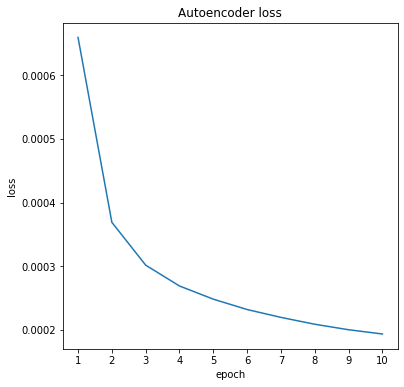

In [9]:
plt.figure(figsize=(6,6))
plt.title('Autoencoder loss')
plt.xticks(range(1,num_epochs+1))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1,num_epochs+1), loss_history_ae,);

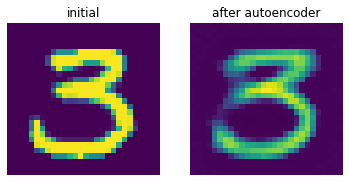

In [10]:
fig = plt.figure(figsize=(6,3))
fig.add_subplot(1, 2, 1)
index = np.random.randint(len(val_data))
img, _ = val_data[index]
plt.title('initial')
plt.axis('off')
plt.imshow(torch.reshape(img, (28,28)));

fig.add_subplot(1, 2, 2)
img = Variable(img).to(device)
img_encoded = autoencoder(img.view(img.shape[0], -1))
img_encoded = torch.reshape(img_encoded, (28, 28))
plt.title('after autoencoder')
plt.axis('off')
plt.imshow(img_encoded.cpu().detach());

###Train classifier

In [11]:
def train_classifier(classifier, autoencoder, criterion, optimizer, dataloaders, dataset_sizes, num_epochs):

  for param in autoencoder.parameters():
    param.requires_grad = False

  best_model_wts = deepcopy(classifier.state_dict())
  best_acc = 0.0

  loss_history = {'train': [], 'val': []}
  acc_history = {'train': [], 'val': []}

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_correct = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.view(inputs.shape[0], -1)
        inputs = Variable(inputs.to(device))
        labels = Variable(labels.to(device))
        optimizer.zero_grad()

        logits = autoencoder.encoder(inputs)
        semantic = logits[:, :10]

        outputs = classifier(semantic)
        _, preds = torch.max(outputs, 1)  
        loss = criterion(outputs, labels)
        if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss += loss.item() * inputs.size(0)
        running_correct += torch.sum(labels == preds.data)

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_correct.double() / dataset_sizes[phase]
      loss_history[phase].append(epoch_loss)
      acc_history[phase].append(epoch_acc)

      if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(classifier.state_dict())

      print('{} epoch [{}/{}], loss: {:.4f}, acc: {:.4f}'.format(
                phase, epoch+1, num_epochs, epoch_loss, epoch_acc))
    print()

  classifier.load_state_dict(best_model_wts)
  return classifier, loss_history, acc_history

In [12]:
model = nn.Sequential(nn.Linear(10,32),nn.ReLU(), nn.Linear(32,10)).to(device)
#model = nn.Sequential(nn.Linear(10,10)).to(device)

criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
num_epochs = 10

In [13]:
classifier, loss_history, acc_history = train_classifier(model, autoencoder, criterion, optimizer, dataloaders, dataset_sizes, num_epochs)

train epoch [1/10], loss: 0.6519, acc: 0.7817
val epoch [1/10], loss: 0.4859, acc: 0.8382

train epoch [2/10], loss: 0.4699, acc: 0.8413
val epoch [2/10], loss: 0.4286, acc: 0.8561

train epoch [3/10], loss: 0.4246, acc: 0.8565
val epoch [3/10], loss: 0.4158, acc: 0.8615

train epoch [4/10], loss: 0.3986, acc: 0.8660
val epoch [4/10], loss: 0.3779, acc: 0.8740

train epoch [5/10], loss: 0.3740, acc: 0.8761
val epoch [5/10], loss: 0.3762, acc: 0.8745

train epoch [6/10], loss: 0.3535, acc: 0.8830
val epoch [6/10], loss: 0.3572, acc: 0.8820

train epoch [7/10], loss: 0.3306, acc: 0.8926
val epoch [7/10], loss: 0.3311, acc: 0.8928

train epoch [8/10], loss: 0.3115, acc: 0.8995
val epoch [8/10], loss: 0.2952, acc: 0.9067

train epoch [9/10], loss: 0.2967, acc: 0.9043
val epoch [9/10], loss: 0.3007, acc: 0.9024

train epoch [10/10], loss: 0.2817, acc: 0.9104
val epoch [10/10], loss: 0.2928, acc: 0.9059



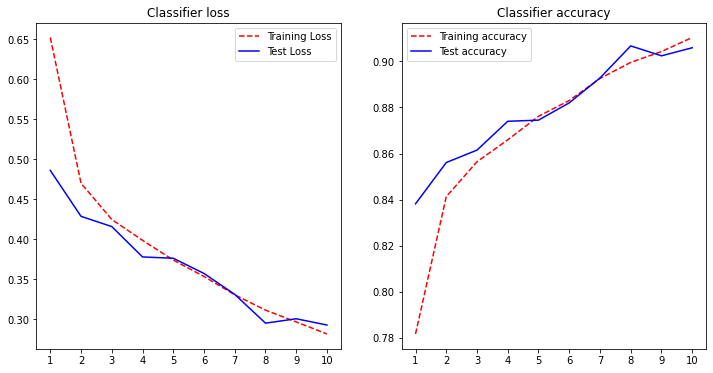

In [14]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Classifier loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Classifier accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);

In [15]:
def classifier_prediction(img, autoencoder, classifier):
  # input is (28, 28) or (1, 28, 28) tensor
  img = torch.reshape(img, (1, 28*28))
  semantic = autoencoder.encoder(img)[:,:10]
  output = classifier(semantic)
  _, preds = torch.max(output, 1)

  return preds.item()


### Build full model with domain adaptation

In [16]:
class Full_model(nn.Module):
  def __init__(self):
      super(Full_model, self).__init__()
      self.autoencoder = Autoencoder()

      self.semantic_classifier = nn.Sequential(
          nn.Linear(10,32),
          nn.ReLU(), 
          nn.Linear(32,10))

      self.nuisance_classifier = nn.Sequential(
          nn.Linear(54, 2)
        )
  def forward(self, img):
      logits = self.autoencoder.encoder(img)
      class_output = self.semantic_classifier(logits[:, :10])
#      _, class_preds = torch.max(class_output, 1)
      domain_output = self.nuisance_classifier(logits[:, 10:])
#      _, domain_preds = torch.max(domain_output, 1)
      return class_output, domain_output



In [17]:
def domain_adaptation_loss(x, y):
    # y - real label vector, size=10, x - semantic classifier prediction
    #loss = -torch.dot(y, nn.LogSoftmax(x[:, :10])) + 
    loss = nn.CrossEntropyLoss(x, y)
    return loss

In [18]:
def train_full_model(model, oprimizer, class_criterion, domain_criterion, dataloaders, num_epochs):

  loss_history = {'train': [], 'val': []}
  acc_history = {'train': [], 'val': []}

  for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        epoch_class_loss = 0.
        epoch_domain_loss = 0.
        running_correct = 0
        running_loss = 0.

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.view(inputs.shape[0], -1)
            inputs = Variable(inputs.to(device))
            class_labels = Variable(labels.to(device))
            domain_labels = torch.zeros(len(inputs)).long()
            domain_labels = Variable(domain_labels.to(device))
            optimizer.zero_grad()

            class_output, domain_output = model(inputs)
            _, class_preds = torch.max(class_output, 1)
            class_loss = class_criterion(class_output, class_labels)
            running_correct += torch.sum(class_labels == class_preds.data)          
            domain_loss = domain_criterion(domain_output, domain_labels)

          #  epoch_class_loss += class_loss
          #  epoch_domain_loss += domain_loss
            loss = (class_loss + domain_loss)
            running_loss += loss * inputs.size(0)
            if phase == 'train':
                loss.backward()
                optimizer.step()

        epoch_acc = running_correct.double() / len(dataloaders[phase].dataset)
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        acc_history[phase].append(epoch_acc)
        loss_history[phase].append(epoch_loss)
            
        print('{} epoch [{}/{}], class acc: {:.4f}, loss: {:.4f}'.format(
                  phase, epoch+1, num_epochs, epoch_acc, epoch_loss))
    
  return model, acc_history, loss_history

        

In [19]:
model = Full_model()
model.autoencoder = autoencoder

params_to_update = chain(model.semantic_classifier.parameters(),model.nuisance_classifier.parameters())

optimizer = torch.optim.Adam(params_to_update, lr=1e-2)

num_epochs = 20

In [20]:
full_model, acc_history, loss_history = train_full_model(model, optimizer, nn.CrossEntropyLoss(), nn.CrossEntropyLoss(), dataloaders, num_epochs)

train epoch [1/20], class acc: 0.7750, loss: 0.6813
val epoch [1/20], class acc: 0.8288, loss: 0.5016
train epoch [2/20], class acc: 0.8348, loss: 0.4909
val epoch [2/20], class acc: 0.8410, loss: 0.4644
train epoch [3/20], class acc: 0.8490, loss: 0.4489
val epoch [3/20], class acc: 0.8564, loss: 0.4380
train epoch [4/20], class acc: 0.8588, loss: 0.4215
val epoch [4/20], class acc: 0.8683, loss: 0.4044
train epoch [5/20], class acc: 0.8670, loss: 0.4035
val epoch [5/20], class acc: 0.8668, loss: 0.4023
train epoch [6/20], class acc: 0.8720, loss: 0.3874
val epoch [6/20], class acc: 0.8755, loss: 0.3814
train epoch [7/20], class acc: 0.8825, loss: 0.3624
val epoch [7/20], class acc: 0.8880, loss: 0.3432
train epoch [8/20], class acc: 0.8918, loss: 0.3397
val epoch [8/20], class acc: 0.8918, loss: 0.3337
train epoch [9/20], class acc: 0.8987, loss: 0.3198
val epoch [9/20], class acc: 0.9008, loss: 0.3061
train epoch [10/20], class acc: 0.9029, loss: 0.3046
val epoch [10/20], class acc:

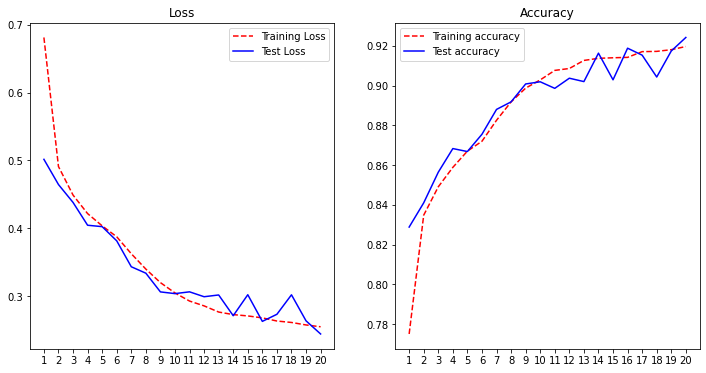

In [21]:
fig = plt.figure(figsize=(12,6))
fig.add_subplot(1, 2, 1)
plt.title('Loss')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), loss_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), loss_history['val'], 'b-')
plt.legend(['Training Loss', 'Test Loss']);

fig.add_subplot(1, 2, 2)
plt.title('Accuracy')
plt.xticks(range(1,num_epochs+1))
plt.plot(range(1,num_epochs+1), acc_history['train'], 'r--')
plt.plot(range(1,num_epochs+1), acc_history['val'], 'b-')
plt.legend(['Training accuracy', 'Test accuracy']);


### Attack it

In [22]:
def attack(model, input, target, num_iter, alpha):
  model.eval()
  with torch.set_grad_enabled(True):
    img = deepcopy(input)
    output_targ = model(target)[:, :10]
    best_loss = 10000.
    best_img = deepcopy(img)
    img = Variable(img, requires_grad=True)
    for i in range(num_iter):
      
      output = model(img)[:, :10]
      loss = torch.norm(output - output_targ, p=2)
      loss.backward(retain_graph=True)

      if loss.item() < best_loss:
        best_loss = loss.item()
        best_img = deepcopy(img)
      
      #step
      img.data -= alpha * torch.sign(img.grad.data)

  return best_img, best_loss

full model prediction:  1
classifier prediction:  1


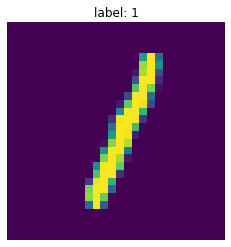

In [33]:
index1 = np.random.randint(len(val_loader.dataset))
img1, label1 = val_loader.dataset[index1]
plt.title('label: {}'.format(label1))
plt.axis('off')
plt.imshow(torch.reshape(img1, (28,28)));

print("full model prediction: ", classifier_prediction(img1, full_model.autoencoder, full_model.semantic_classifier))
print("classifier prediction: ", classifier_prediction(img1, autoencoder, classifier))

full model prediction:  2
classifier prediction:  2


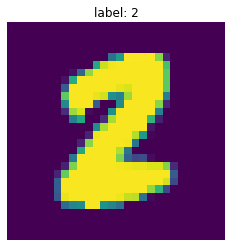

In [29]:
index2 = np.random.randint(len(val_loader.dataset))
img2, label2 = val_loader.dataset[index2]
plt.title('label: {}'.format(label2))
plt.axis('off')
plt.imshow(torch.reshape(img2, (28,28)));

print("full model prediction: ", classifier_prediction(img2, full_model.autoencoder, full_model.semantic_classifier))
print("classifier prediction: ", classifier_prediction(img2, autoencoder, classifier))

with domain adaptation:  2
no domain adaptation:  2


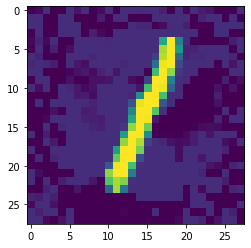

In [36]:
adv, _ = attack(full_model.autoencoder.encoder, torch.reshape(img1, (1, 28*28)),
                torch.reshape(img2, (1, 28*28)), 20, 1./255)

plt.imshow(torch.reshape(adv, (28, 28)).detach());
print("with domain adaptation: ", classifier_prediction(adv, full_model.autoencoder, full_model.semantic_classifier))
print("no domain adaptation: ", classifier_prediction(adv, autoencoder, classifier))

### JPEG for MNIST

In [ ]:
def to_jpg_and_back(img):
  img = img.data.cpu().numpy()

  #make jpg
  img = img * 255.0
  img = np.clip(img, 0, 255).astype(np.uint8)
  img_pil = torchvision.transforms.ToPILImage()(img)
  img_pil.save('img.jpg', 'JPEG')

  #back to tensor
  img_back = (np.asarray(Image.open('img.jpg')) / 255.0).astype(np.float32)
  transform = transforms.ToTensor()
  img_back = transform(img_back)
  img_back = torch.reshape(img_back, (1, 28, 28))
  
  return img_back

classifier prediction:  8


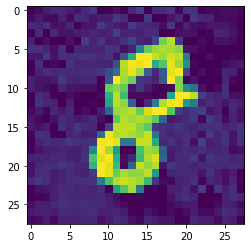

In [ ]:
adv_jpg = to_jpg_and_back(torch.reshape(adv, (28, 28)))
plt.imshow(adv_jpg[0])

print('classifier prediction: ', classifier_prediction(adv_jpg))